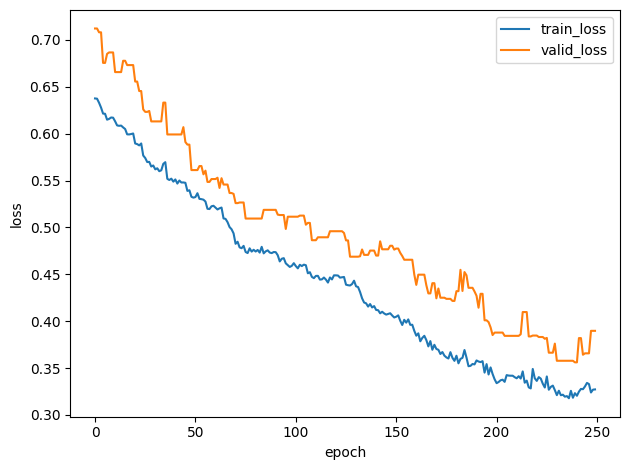

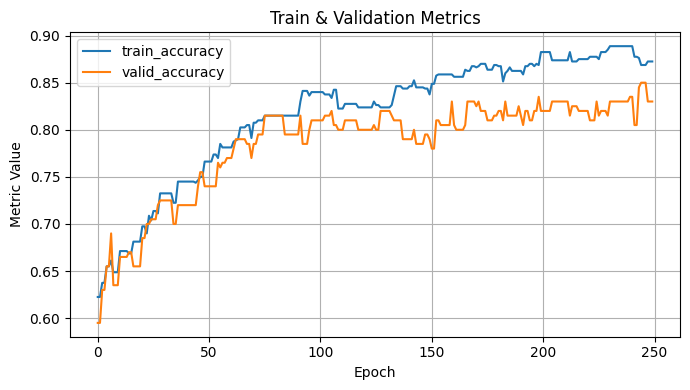

In [21]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

from pyperch import Perch
from pyperch.models import SimpleMLP
from pyperch.utils import plot_losses, plot_metrics
from pyperch.core.metrics import Accuracy

# -------------------------------------------------------------------
# 1. Reproducibility
# -------------------------------------------------------------------
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# -------------------------------------------------------------------
# 2. Generate dataset
# -------------------------------------------------------------------
X, y = make_classification(
    n_samples=1000,
    n_features=12,
    n_informative=10,
    n_classes=2,
    random_state=seed,
)

X = X.astype(np.float32)
y = y.astype(np.int64)

# -------------------------------------------------------------------
# 3. Builder version (replaces model + loaders + TrainConfig)
# -------------------------------------------------------------------
perch = (
    Perch()
    .model(
        SimpleMLP,
        input_dim=12,
        hidden=[32],
        output_dim=2,
        activation="relu",
        loss_fn=nn.CrossEntropyLoss(),
    )
    .optimizer("rhc", step_size=0.05)
    .metrics(Accuracy())
    .data(
        X,
        y,
        batch_size=64,
        valid_split=0.2,
        stratify=True,
        normalize=None,
    )
)

# -------------------------------------------------------------------
# 4. Train
# -------------------------------------------------------------------
trainer, history = perch.train(
    max_epochs=250,
    seed=seed,
    optimizer_mode="per_epoch",
)

# -------------------------------------------------------------------
# 5. Plots
# -------------------------------------------------------------------
plot_losses(history)
plt.show()

plot_metrics(history)
plt.show()



Final train loss: 1752.893817608173
Final valid loss: 2306.3631591796875
Final train R^2: 0.9407165857704259
Final valid R^2: 0.9299652993260061


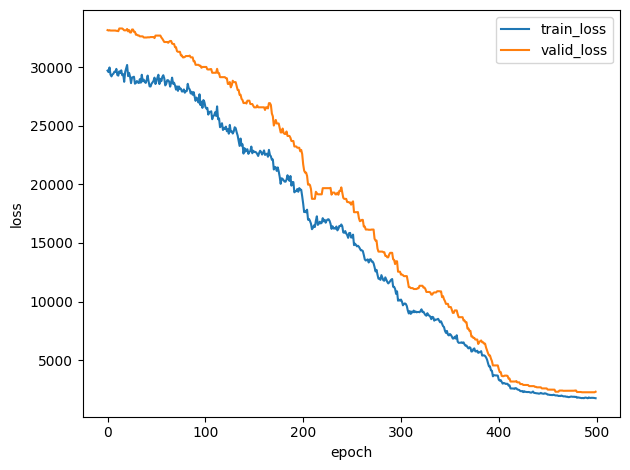

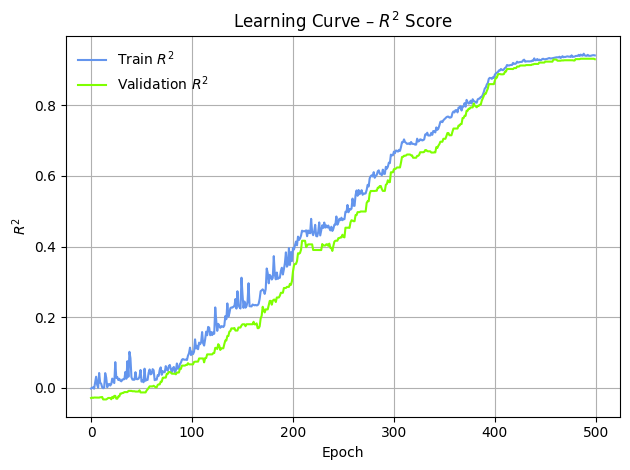

In [11]:
#REGRESSION
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from pyperch import Trainer
from pyperch.config import TrainConfig, OptimizerConfig
from pyperch.core.metrics import MSE, R2
from pyperch.utils import plot_losses, plot_metrics

# -------------------------------------------------------------------
# 1. Reproducibility
# -------------------------------------------------------------------
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# -------------------------------------------------------------------
# 2. Regression dataset
# -------------------------------------------------------------------
X, y = make_regression(
    n_samples=1000,
    n_features=12,
    n_informative=10,
    noise=0.2,
    random_state=seed,
)

X = X.astype(np.float32)
y = y.reshape(-1, 1).astype(np.float32)  # 2D target

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
valid_ds = TensorDataset(torch.tensor(X_valid), torch.tensor(y_valid))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=128)

# -------------------------------------------------------------------
# 3. Simple MLP regressor
# -------------------------------------------------------------------
class SimpleRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(12, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        return self.net(x)


model = SimpleRegressor()
loss_fn = nn.MSELoss()

# -------------------------------------------------------------------
# 4. RHC optimizer config + metrics (MSE + R²)
# -------------------------------------------------------------------
opt_cfg = OptimizerConfig(
    name="rhc",
    step_size=0.5,
)

cfg = TrainConfig(
    device="cpu",
    seed=seed,
    max_epochs=500,              # tweak as needed
    optimizer="rhc",
    optimizer_config=opt_cfg,
    optimizer_mode="per_epoch", # can try "per_batch" later
    metrics={
        "train": [MSE(), R2()],
        "valid": [MSE(), R2()],
    },
    callbacks=[],
)

# -------------------------------------------------------------------
# 5. Train
# -------------------------------------------------------------------
trainer = Trainer(model, loss_fn, cfg)
history = trainer.fit(train_loader, valid_loader)

# -------------------------------------------------------------------
# 6. Plot loss learning curve (train + valid)
# -------------------------------------------------------------------
plot_losses(history)

# -------------------------------------------------------------------
# 7. Plot R² learning curve (train + valid)
# -------------------------------------------------------------------
epochs = history["epoch"]
train_r2 = history["train_metrics"].get("r2", [])
valid_r2 = history["valid_metrics"].get("r2", [])

plt.figure()
if train_r2:
    plt.plot(epochs, train_r2, label="Train $R^2$", color="cornflowerblue")
if valid_r2:
    plt.plot(epochs, valid_r2, label="Validation $R^2$", color="chartreuse")

plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.title(r"Learning Curve – $R^2$ Score")
plt.grid(True)
plt.legend(frameon=False)
plt.tight_layout()

print("Final train loss:", history["train_loss"][-1])
print("Final valid loss:", history["valid_loss"][-1])
if train_r2:
    print("Final train R^2:", train_r2[-1])
if valid_r2:
    print("Final valid R^2:", valid_r2[-1])



Frozen layer unchanged: True


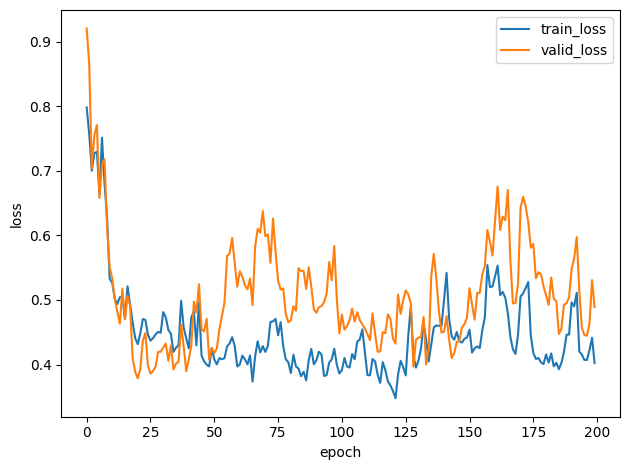

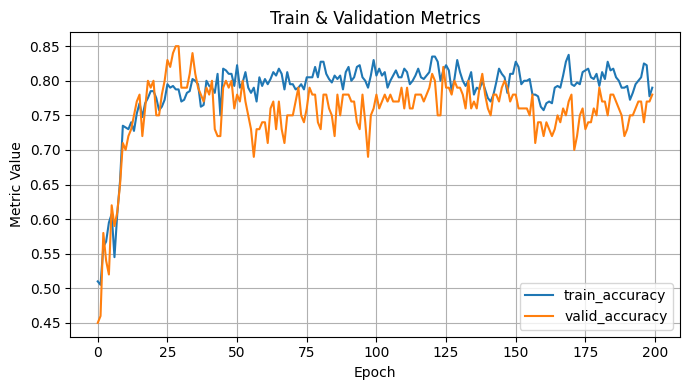

In [2]:
#freezing

# freezing test using Perch builder

import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

from pyperch import Perch
from pyperch.utils import plot_losses, plot_metrics
from pyperch.core.callbacks import CaptureInitialWeights

# ------------------------------------------------------------
# Dummy dataset
# ------------------------------------------------------------
np.random.seed(42)
X = np.random.randn(500, 10).astype(np.float32)
y = (np.sum(X[:, :3], axis=1) > 0).astype(np.int64)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
valid_ds = TensorDataset(torch.tensor(X_valid), torch.tensor(y_valid))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=32, shuffle=False)

# ------------------------------------------------------------
# Simple test model
# ------------------------------------------------------------
class SimpleClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(10, 16),
            nn.ReLU(),
            nn.Linear(16, 2),
        )

    def forward(self, x):
        return self.net(x)

# ------------------------------------------------------------
# Build experiment with freeze + meta
# ------------------------------------------------------------
perch = (
    Perch()
    .model(SimpleClassifier, loss_fn=nn.CrossEntropyLoss())
    .freeze("net.0.weight", "net.0.bias")     # frozen layer
    .meta_opt("net.2.weight", "net.2.bias")   # meta (RHC) layer
    .optimizer("rhc", step_size=0.5)
    .metrics("accuracy")
    .data_loaders(train_loader, valid_loader)
)

# ------------------------------------------------------------
# Capture frozen weights BEFORE training
# ------------------------------------------------------------
cap = CaptureInitialWeights("net.0.weight")

trainer, history = perch.callbacks(cap).train(
    max_epochs=200,
    seed=42,
    optimizer_mode="per_batch",
)

# ------------------------------------------------------------
# Verify freeze
# ------------------------------------------------------------
initial = cap.initial["net.0.weight"]
final = trainer.model.net[0].weight.detach()

unchanged = torch.allclose(initial, final)
print("Frozen layer unchanged:", unchanged)

# ------------------------------------------------------------
# Plots
# ------------------------------------------------------------
plot_losses(history)
plot_metrics(history)


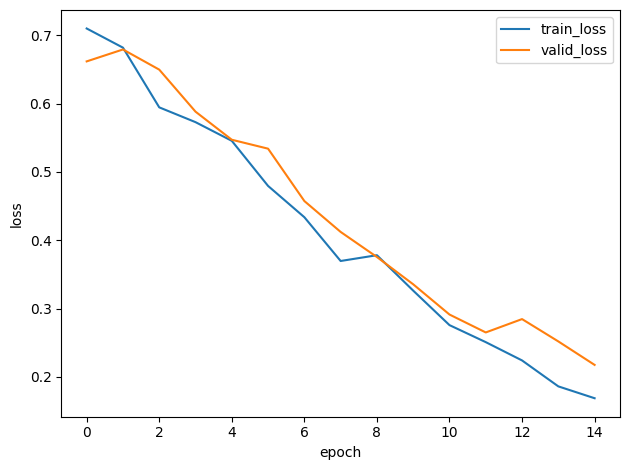

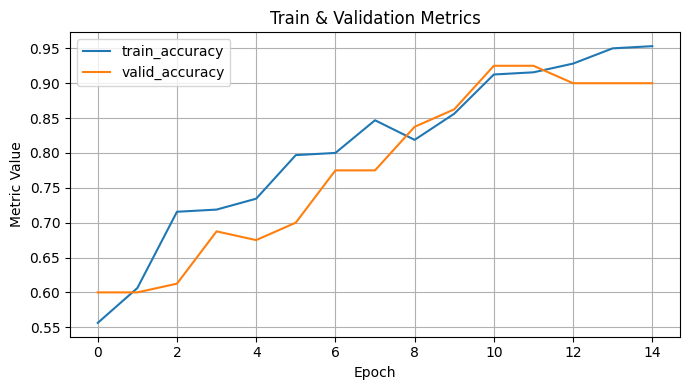

In [15]:
#hybrid test: 

# ------------------------------------------------------------
# Hybrid Layer Modes: grad + meta
# ------------------------------------------------------------

import numpy as np
import torch
from torch import nn
from sklearn.model_selection import train_test_split

from pyperch import Perch
from pyperch.models import SimpleMLP
from pyperch.utils import plot_losses, plot_metrics

# ------------------------------------------------------------
# Dummy dataset
# ------------------------------------------------------------
np.random.seed(42)
X = np.random.randn(500, 10).astype(np.float32)
y = (np.sum(X[:, :3], axis=1) > 0).astype(np.int64)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ------------------------------------------------------------
# Builder test USING SimpleMLP
# ------------------------------------------------------------
perch = (
    Perch()
    .model(
        SimpleMLP,
        input_dim=10,
        hidden=[16],
        output_dim=2,
        activation="relu",
        loss_fn=nn.CrossEntropyLoss(),
    )
    # Adam on first layer
    .grad_opt("net.0.weight", "net.0.bias")
    # RHC on output layer
    .meta_opt("net.2.weight", "net.2.bias")
    .optimizer("rhc", step_size=0.5)
    .torch_optimizer("adam", lr=1e-3)
    .metrics("accuracy")
    .data(X_train, y_train, batch_size=32, valid_split=0.2)
)

trainer, history = perch.train(
    max_epochs=15,
    seed=42,
    optimizer_mode="per_batch",
)

plot_losses(history)
plot_metrics(history)


Frozen layer unchanged: True


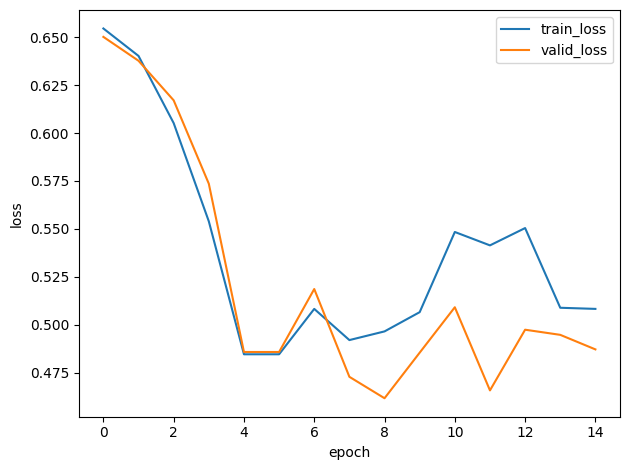

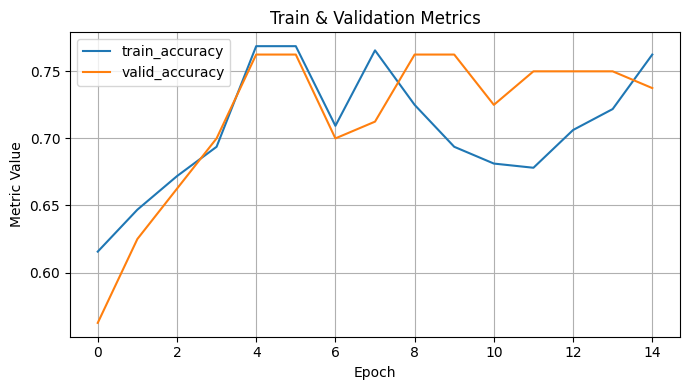

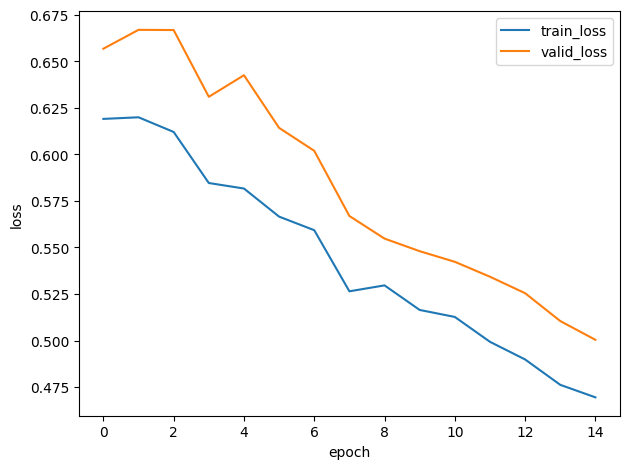

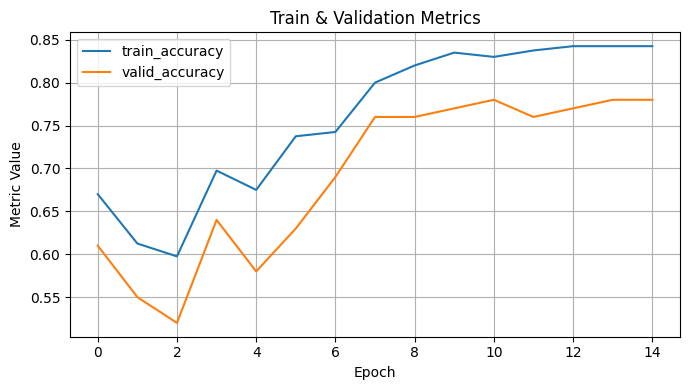

In [1]:
#freeze + hybrid
# ------------------------------------------------------------
# Freeze first layer
# Train middle with Adam
# Train output with RHC
# ------------------------------------------------------------
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import train_test_split

from pyperch import Perch
from pyperch.models import SimpleMLP
from pyperch.utils import plot_losses, plot_metrics

# ------------------------------------------------------------
# Dummy Classification Dataset
# ------------------------------------------------------------
np.random.seed(42)
X = np.random.randn(500, 10).astype(np.float32)
y = (np.sum(X[:, :3], axis=1) > 0).astype(np.int64)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ------------------------------------------------------------
# Builder version of freeze + hybrid RHC
# ------------------------------------------------------------
perch = (
    Perch()
    .model(
        SimpleMLP,
        input_dim=10,
        hidden=[16],
        output_dim=2,
        activation="relu",
        loss_fn=nn.CrossEntropyLoss(),
    )
    # Freeze first Linear layer
    .freeze("net.0.weight", "net.0.bias")

    # RHC (meta) for output layer
    .meta_opt("net.2.weight", "net.2.bias")

    # Meta optimizer config
    .optimizer("rhc", step_size=0.5)

    # Accuracy (train + valid)
    .metrics("accuracy")

    # Data
    .data(X_train, y_train, batch_size=32, valid_split=0.2)
)

trainer, history = perch.train(
    max_epochs=15,
    seed=42,
    optimizer_mode="per_batch",
)

# ------------------------------------------------------------
# Plots
# ------------------------------------------------------------
plot_losses(history)
plot_metrics(history)



import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

from pyperch import Perch
from pyperch.models import SimpleMLP
from pyperch.core.metrics import Accuracy
from pyperch.utils import plot_losses, plot_metrics
from pyperch.core.callbacks import CaptureInitialWeights

# ------------------------------------------------------------
# Dummy dataset
# ------------------------------------------------------------
np.random.seed(42)
torch.manual_seed(42)
X = np.random.randn(500, 10).astype(np.float32)
y = (X[:, :3].sum(axis=1) > 0).astype(np.int64)

# ------------------------------------------------------------
# Build FREEZE + RHC hybrid model
# ------------------------------------------------------------
perch = (
    Perch()
    .model(
        SimpleMLP,
        input_dim=10,
        hidden=[16],
        output_dim=2,
        activation="relu",
        loss_fn=nn.CrossEntropyLoss(),
    )
    # ------------------------------
    # Layer modes
    # ------------------------------
    .freeze("net.0.weight", "net.0.bias")        # FROZEN LAYER
    .meta_opt("net.2.weight", "net.2.bias")      # RHC-optimized layer
    # ------------------------------
    # Optimizer (meta)
    # ------------------------------
    .optimizer(
        "rhc",
        step_size=0.05,
    )
    # ------------------------------
    # Metrics + Data
    # ------------------------------
    .metrics("accuracy")
    .data(
        X,
        y,
        batch_size=32,
        valid_split=0.2,
        stratify=False,
    )
)

# ------------------------------------------------------------
# Capture initial frozen weights (to verify freezing)
# ------------------------------------------------------------
cap = CaptureInitialWeights("net.0.weight")

trainer, history = perch.callbacks(cap).train(
    max_epochs=15,
    seed=42,
    optimizer_mode="per_batch",
)

# ------------------------------------------------------------
# Verify frozen layer did not change
# ------------------------------------------------------------
initial = cap.initial["net.0.weight"]
final = trainer.model.net[0].weight.detach()

print("Frozen layer unchanged:", torch.allclose(initial, final))

# ------------------------------------------------------------
# Plots
# ------------------------------------------------------------
plot_losses(history)
plt.show()

plot_metrics(history)
plt.show()

